## Overview

In the previous notebook, we learnt how to use [Xarray](http://xarray.pydata.org/) to work with gridded datasets. XArray is also well suited to work with georeferenced rasters - such as satellite imagery, population grids, or elevation data.[rioxarray](https://corteva.github.io/rioxarray/stable/index.html) is an extension of xarray that makes it easy to work with geospatial rasters. You can install the `rioxarray` package from the `conda-forge` channel.

In this section, we will take 4 individual SRTM tiles around the Mt. Everest region and merge them to a single GeoTiff using RasterIO. We will also use `matplotlib` to visualize the result with some annonations.

## Setup and Data Download

The following blocks of code will install the required packages and download the datasets to your Colab environment.

In [ ]:
%%capture
if 'google.colab' in str(get_ipython()):
    !pip install --quiet rioxarray

By convention, `rioxarray` is imported as `rxr`.

> Remember to always import `rioxarray` even if you are using sub-modules such as `merge_arrays`. Importing `rioxarray` activates the `rio` accessor which is required for all operations.

In [1]:
import os
import rioxarray as rxr
from rioxarray.merge import merge_arrays
import matplotlib.pyplot as plt

In [2]:
data_folder = 'data'
output_folder = 'output'

if not os.path.exists(data_folder):
    os.mkdir(data_folder)
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

In [3]:
def download(url):
    filename = os.path.join(data_folder, os.path.basename(url))
    if not os.path.exists(filename):
        from urllib.request import urlretrieve
        local, _ = urlretrieve(url, filename)
        print('Downloaded ' + local)

srtm_tiles = [
  'N27E086.hgt',
  'N27E087.hgt',
  'N28E086.hgt',
  'N28E087.hgt'
]

data_url = 'https://github.com/spatialthoughts/python-dataviz-web/raw/main/data/srtm/'

for tile in srtm_tiles:
  url = '{}/{}'.format(data_url, tile)
  download(url)

Downloaded data/N27E086.hgt
Downloaded data/N27E087.hgt
Downloaded data/N28E086.hgt
Downloaded data/N28E087.hgt


## Rioxarray Basics

The `open_rasterio()` method from `rioxarray` is able to read any data source supported by. the [`rasterio`](https://rasterio.readthedocs.io/en/latest/) library. Let's open a single Shuttle Radar Topography Mission [SRTM](https://www.usgs.gov/centers/eros/science/usgs-eros-archive-digital-elevation-shuttle-radar-topography-mission-srtm-1) tile using `rioxarray`.

In [5]:
filename = 'N28E087.hgt'
file_path = os.path.join(data_folder, filename)
rds = rxr.open_rasterio(file_path)

The result is a `xarray.DataArray` object.

In [6]:
rds

<xarray.DataArray (band: 1, y: 3601, x: 3601)>
[12967201 values with dtype=int16]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 87.0 87.0 87.0 87.0 87.0 ... 88.0 88.0 88.0 88.0
  * y            (y) float64 29.0 29.0 29.0 29.0 29.0 ... 28.0 28.0 28.0 28.0
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Point
    _FillValue:     -32768
    scale_factor:   1.0
    add_offset:     0.0
    units:          m

You can access the pixel values using the `values` property which returns the array’s data as a numpy array.

In [7]:
rds.values

array([[[5217, 5211, 5208, ..., 5097, 5098, 5089],
        [5206, 5201, 5200, ..., 5080, 5075, 5069],
        [5199, 5194, 5191, ..., 5063, 5055, 5048],
        ...,
        [5347, 5345, 5343, ..., 5747, 5750, 5757],
        [5338, 5338, 5336, ..., 5737, 5740, 5747],
        [5332, 5331, 5332, ..., 5734, 5736, 5744]]], dtype=int16)

A `xarray.DataArray` object also contains 1 or more `coordinates`. Each coordinate is a 1-dimensional array representing values along one of the data axes. In case of the 1-band SRTM elevation data, we have 3 coordinates - `x`, `y` and `band`.

In [ ]:
rds.coords

The raster metadata is stored in the [`rio`](https://corteva.github.io/rioxarray/stable/rioxarray.html#rioxarray-rio-accessors) accessor. This is enabled by the `rioxarray` library which provides geospatial functions on top of `xarray`.

In [8]:
print('CRS:', rds.rio.crs)
print('Resolution:', rds.rio.resolution())
print('Bounds:', rds.rio.bounds())
print('Width:', rds.rio.width)
print('Height:', rds.rio.height)

CRS: EPSG:4326
Resolution: (0.0002777777777777778, -0.0002777777777777778)
Bounds: (86.99986111111112, 27.999861111111112, 88.00013888888888, 29.000138888888888)
Width: 3601
Height: 3601


In [9]:
band1 = rds.sel(band=1)
band1

<xarray.DataArray (y: 3601, x: 3601)>
array([[5217, 5211, 5208, ..., 5097, 5098, 5089],
       [5206, 5201, 5200, ..., 5080, 5075, 5069],
       [5199, 5194, 5191, ..., 5063, 5055, 5048],
       ...,
       [5347, 5345, 5343, ..., 5747, 5750, 5757],
       [5338, 5338, 5336, ..., 5737, 5740, 5747],
       [5332, 5331, 5332, ..., 5734, 5736, 5744]], dtype=int16)
Coordinates:
    band         int64 1
  * x            (x) float64 87.0 87.0 87.0 87.0 87.0 ... 88.0 88.0 88.0 88.0
  * y            (y) float64 29.0 29.0 29.0 29.0 29.0 ... 28.0 28.0 28.0 28.0
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Point
    _FillValue:     -32768
    scale_factor:   1.0
    add_offset:     0.0
    units:          m

In [10]:
band1.values

array([[5217, 5211, 5208, ..., 5097, 5098, 5089],
       [5206, 5201, 5200, ..., 5080, 5075, 5069],
       [5199, 5194, 5191, ..., 5063, 5055, 5048],
       ...,
       [5347, 5345, 5343, ..., 5747, 5750, 5757],
       [5338, 5338, 5336, ..., 5737, 5740, 5747],
       [5332, 5331, 5332, ..., 5734, 5736, 5744]], dtype=int16)

## Plotting Multiple Rasters

Open each source file using `open_rasterio()` method and store the resulting datasets in a list.

In [11]:
# create an empty list to store datasets
datasets = []

for tile in srtm_tiles:
    path = os.path.join(data_folder, tile)
    rds = rxr.open_rasterio(path)
    band = rds.sel(band=1)
    datasets.append(band)

You can visualize any `DataArray` object by calling `plot()` method. Here we create a subplot with 1 row and 4 columns. The `subplots()` method will return a list of Axes that we can use to render each of the source SRTM rasters. For plots with multiple columns, the Axes will be a nested list. To easily iterate over it, we can use `.flat` which returns a 1D iterator on the axes.

While plotting the data, we can use the `cmap` option to specify a color ramp. Here we are using the built-in *Greys* ramp. Appending **_r** gives us the inverted ramp with blacks representing lower elevation values.

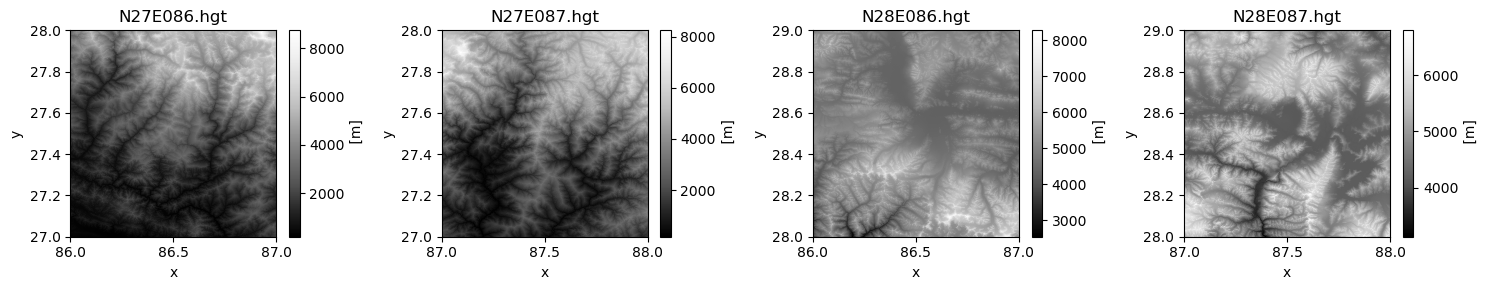

In [12]:
fig, axes = plt.subplots(1, 4) # 1 row x 4 cols
fig.set_size_inches(15,3)

for index, ax in enumerate(axes.flat): # enumerate iterates through the axes and keep track of their index
    da = datasets[index]  # loops through the datasets list 
    im = da.plot.imshow(ax=ax, cmap='Greys_r') # plots each dataset - note _r suffix reverses the specified color map
    filename = srtm_tiles[index] # list of files defined earlier
    ax.set_title(filename)

plt.tight_layout()
plt.show()

## Merging Rasters

Now that you understand the basic data structure of *xarray* and the &rio* extension, let's use it to process some data. We will take the 4 individual SRTM tiles (as specified earlier) and merge them to a single [GeoTiff](https://en.wikipedia.org/wiki/GeoTIFF). You will note that `rioxarray` handles the CRS and transform much better - taking care of internal details and providing a simple API.

We will use the `merge_arrays()` method from the `rioxarray.merge` module to merge the rasters. We can also specify an optional `method` that controls how overlapping tiles are merged. Here we have chosen `first` which takes the value of the first raster in the overlapping region.

Reference: [`merge_arrays()`](https://corteva.github.io/rioxarray/html/rioxarray.html#rioxarray.merge.merge_arrays)

In [17]:
merged = merge_arrays(datasets, method='first')  # overlapping tiles merged on first raster value
merged

<xarray.DataArray (y: 7201, x: 7201)>
array([[4916, 4926, 4931, ..., 5097, 5098, 5089],
       [4919, 4932, 4928, ..., 5080, 5075, 5069],
       [4919, 4928, 4935, ..., 5063, 5055, 5048],
       ...,
       [ 368,  368,  366, ..., 1905, 1919, 1937],
       [ 364,  364,  362, ..., 1913, 1930, 1944],
       [ 360,  359,  357, ..., 1918, 1930, 1942]], dtype=int16)
Coordinates:
  * x            (x) float64 86.0 86.0 86.0 86.0 86.0 ... 88.0 88.0 88.0 88.0
  * y            (y) float64 29.0 29.0 29.0 29.0 29.0 ... 27.0 27.0 27.0 27.0
    band         int64 1
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Point
    _FillValue:     -32768
    scale_factor:   1.0
    add_offset:     0.0
    units:          m

We can now visualize the merged raster.

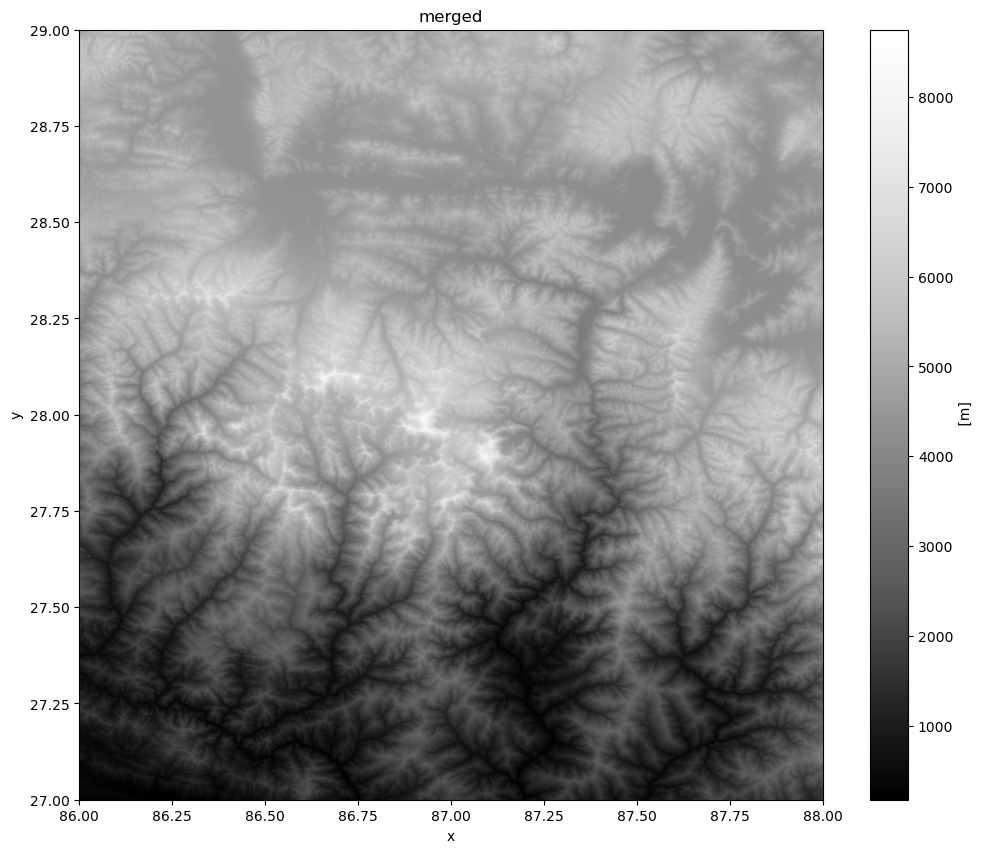

In [18]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 10)
merged.plot.imshow(ax=ax, cmap='Greys_r')
ax.set_title('merged')
plt.show()

## Annotating Plots

Sometime it is helpful to add annotations on your plot to highlight a feature or add a text label. In this section we will learn how to use the annotate the Digital Elevation Model (DEM) to show the location and elevation of Mt. Everest.

First, we locate the coordinates of the maximum elevation in the `merged` DataArray using the `max()` function. We can then use `where()` function to filter the elements where the value equals the maximum elevation. Lastly, we run `squeeze()` to remove the extra empty dimension from the result.

References:

* [xarray.DataArray.max](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.max.html)
* [xarray.DataArray.where](https://docs.xarray.dev/en/stable/generated/xarray.DataArray.where.html)

In [19]:
max_da = merged.where(merged==merged.max(), drop=True).squeeze()
max_da

<xarray.DataArray ()>
array(8748.)
Coordinates:
    x            float64 86.93
    y            float64 27.99
    band         int64 1
    spatial_ref  int64 0
Attributes:
    AREA_OR_POINT:  Point
    _FillValue:     -32768
    scale_factor:   1.0
    add_offset:     0.0
    units:          m

We now extract the x,y coordinates and the value of the maximum elevation.

In [31]:
# extract x and y coordinates of maximum elevation
max_x = max_da.x.values
max_y = max_da.y.values


max_x_list = max_x.tolist()
max_y_list = max_y.tolist()

# extract max elevation in metres
max_elev = int(max_da.values)

print(f'The coordinates of the highest point are {max_x_list, max_y_list} and the highest point is {max_elev} metres.')

The coordinates of the highest point are (86.92555555555556, 27.988888888888887) and the highest point is 8748 metres.


Now we plot the `merged` raster and annotate it using the `annotate()` function.

Reference: [matplotlib.pyplot.annotate
](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.annotate.html)

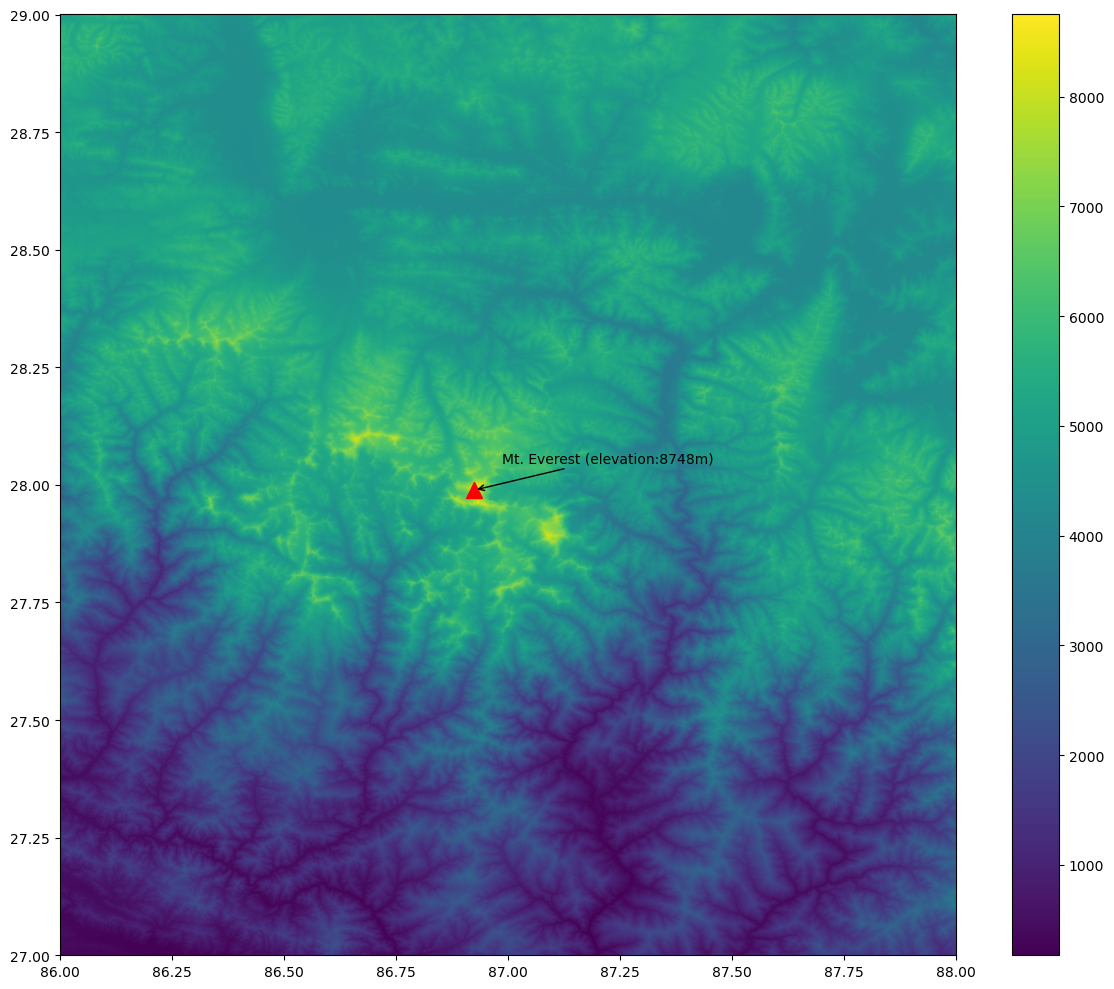

In [33]:
# tee up the plot
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 10)

# plot the merged raster
merged.plot.imshow(ax=ax, cmap='viridis', add_labels=False)
ax.plot(max_x, max_y, '^r', markersize=11)
ax.annotate('Mt. Everest (elevation:{}m)'.format(max_elev),
            xy=(max_x, max_y), xycoords='data',
            xytext=(20, 20), textcoords='offset points',
            arrowprops=dict(arrowstyle='->', color='black')
            )
plt.tight_layout()
plt.show()

Finally, save the merged array to disk as a GeoTiff file.

In [34]:
output_filename = 'merged.tif'
output_path = os.path.join(output_folder, output_filename)
merged.rio.to_raster(output_path)

## Exercise

Add contours to the elevation plot below. You can use the [`xarray.plot.contour`](https://docs.xarray.dev/en/stable/generated/xarray.plot.contour.html) function to create the contour plot.

Hint: Use the options `colors=black` and `levels=10`.

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 10)
merged.plot.imshow(ax=ax, cmap='viridis', add_labels=False)
plt.tight_layout()
plt.show()

## My solution

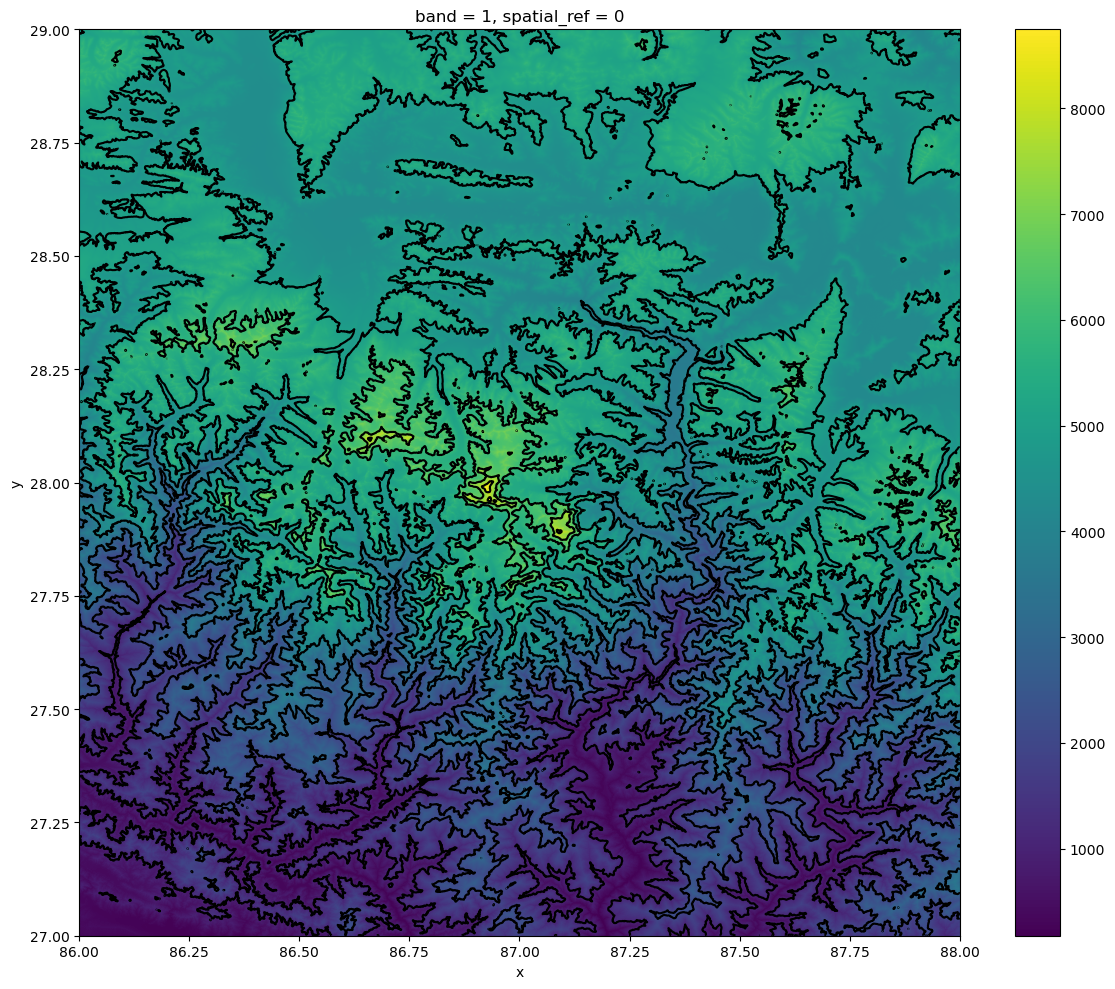

In [37]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(12, 10)
merged.plot.imshow(ax=ax, cmap='viridis', add_labels=False)
merged.plot.contour(ax=ax, colors='black', levels=10)
plt.tight_layout()
plt.show()